# Sentiment analysis of match thread

To run this yourself. Two things have to be done manually:

1. Set up PhantomJS with Selenium (This has gotten easier to install (not sure if PhantomJS now comes with Selenium by default or you still have to download it seperately). Used to be a pain.)

2. Get a client_id / client_secret set up with PRAW / Reddit. In this code it is assumed that there is a file called: *praw.json* which contains client_id, client_secret, password, user_agent, and username.

Tweaks will need to be made before the match events are fully automatic.

Notebooks are run in the main directory of the repository (and just archived in the notebook folder). So paths will have to be modified if you run the notebook in the notebook folder

### Import packages

In [1]:
import praw
import datetime
import pandas as pd
import nltk.sentiment.vader
import matplotlib.pyplot as plt
# Import all relevant packages
from bs4 import BeautifulSoup
from selenium import webdriver
import numpy as np
import os

###  Some parameters

These need to be changed every match

In [2]:
url = 'http://www.telegraph.co.uk/football/2017/08/12/watford-vs-liverpool-premier-league-live-score-updates-team/'
thread_id = '6t7tx3'
analysis_name = 'League_1_Watford'

###  More parameters

These parameters and definitions that don't need to change each game

In [3]:
# Define some objects to be used later
# set up driver for scraping
driver = webdriver.PhantomJS()
# Define  NLTK object
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()
# set matplotlib style
plt.style.use('ggplot')
# Change this to 0 if you have downloaded the data and want to redownload
use_saved_data = 1

###  Function definitions

Six funcitons that do most of the work

In [4]:
def get_match_report(url):
    """
    Function gets all times and titles of telegraph match report

    """
    #Open page and make a soup object
    driver.get(url)
    r = driver.page_source
    soup = BeautifulSoup(r, 'lxml')
    #This finds a list of all links which are connected to a concept
    updates = soup.findAll('div', class_='live-post js-live-post component')
    titles = soup.findAll('h3', class_='live-post__title')
    titles = [t.text.lower() for t in titles]

    tele_times = [u.find('a').text for u in updates]
    tele_times_dt = []
    for t in tele_times:
        t = t.split(':')
        if t[1][-2:] == 'AM' or t[0] == '12':
            tele_times_dt.append(datetime.time(int(t[0]),int(t[1][:-2])))
        else:
            tele_times_dt.append(datetime.time(int(t[0])+12,int(t[1][:-2])))

    return titles,tele_times_dt

def get_comments(thread_id,praw_info):
    reddit = praw.Reddit(client_id=praw_info['client_id'][0],
                         client_secret=praw_info['client_secret'][0],
                         password=praw_info['password'][0],
                         user_agent=praw_info['user_agent'][0],
                         username=praw_info['username'][0])
    submission = reddit.submission(id=thread_id)
    submission.comments.replace_more(limit=None, threshold = 0)
    return submission

def comment_time_and_sentiment(submission):
    time = []
    sentiment = []
    score = []
    # Loop through top comments and add to time and sentiment list
    for top_level_comment in submission.comments:
        time.append((datetime.datetime.fromtimestamp(top_level_comment.created_utc) - datetime.timedelta(hours=1)))
        sentiment.append(vader.polarity_scores(top_level_comment.body)['compound'])
        score.append(top_level_comment.score)
    # Make time format
    pd_time = pd.to_datetime(time)
    # Make to dateframe
    df = pd.DataFrame(data={'sentiment': sentiment,'score':score}, index = pd_time)
    return df

def posneg_sentiment_difference(df,bins='1min'):
    # Find comments with positive > 0 and negative < 0 sentiment
    pdf = df[df['sentiment'] > 0]
    ndf = df[df['sentiment'] < 0]

    # Bin
    pgdf = pdf.groupby(pd.TimeGrouper(freq=bins)).count()
    ngdf = ndf.groupby(pd.TimeGrouper(freq=bins)).count()
    diff_df = (pgdf['sentiment']-ngdf['sentiment']).dropna()
    return diff_df


def weighted_posneg_sentiment_difference(df,bins='1min'):
    # Find comments with positive > 0 and negative < 0 sentiment
    df = pd.DataFrame(df[df['score']>0])
    pdf = df[df['sentiment'] > 0]
    ndf = df[df['sentiment'] < 0]
    # Bin
    pgdf = pdf.groupby(pd.TimeGrouper(freq=bins)).count()
    ngdf = ndf.groupby(pd.TimeGrouper(freq=bins)).count()
    # Take the difference
    diff_df = (pgdf['sentiment']*pgdf['score']-ngdf['sentiment']*ngdf['score']).dropna()
    return diff_df


def plot_figure(df,ax):
    # Main line
    ax.plot(df.index.time,df,linewidth=2,color='firebrick')
    # Scale y axis (make even -/+ directions)
    ax.set_ylim([-np.max(np.abs(ax.get_ylim())),np.max(np.abs(ax.get_ylim()))])
    # Make axis ticks and labels correct
    ax.set_xlim(datetime.time(12,00),datetime.time(15,00))
    ax.set_xticks([ax.get_xlim()[0]+m*60 for m in range(0,181,30)])
    ax.set_xlabel('Time (GMT/BST)')
    return ax

###  Get comments and sentiment score

If the data already exists, it loads that (remember to run in main directory, not notebook directory)

In [5]:
# If data doesn't exist, download it. If data exists, load it.
if use_saved_data == 1 and os.path.exists('./data/' + analysis_name + '.csv'):
    df = pd.read_csv('./data/' + analysis_name + '.csv', index_col=0, parse_dates=[0])
else:
    # read in reddit api info
    praw_info = pd.read_json('praw.json')
    # do the sentiment analysis
    submission = get_comments(thread_id,praw_info)
    df = comment_time_and_sentiment(submission)
    df.to_csv('./data/' + analysis_name +  '.csv')
    # Delete reddit api info
    praw_info = {}

### Get match report

In [6]:
titles,matchevents = get_match_report(url)

### Parse match report

I have no idea if these are universal ways the match thread are, but works at least for this game (needs to be check in other games).

So this will be improved in future.

In [7]:
goal = [matchevents[i] for i,t in enumerate(titles) if t == 'goal!']
penalty = [matchevents[i] for i,t in enumerate(titles) if t[:7] == 'penalty']
halftime = [matchevents[i] for i,t in enumerate(titles) if t[:2] == 'ht']
fulltime = [matchevents[i] for i,t in enumerate(titles) if t[:2] == 'ft']
kickoff = [matchevents[i] for i,t in enumerate(titles) if t[:9] == 'we\'re off']

### Get positive/negative difference

Sort into number of positive and number of negative comments

In [8]:
posneg_df = posneg_sentiment_difference(df,bins='2min')
weighted_posneg_df = weighted_posneg_sentiment_difference(df,bins='1min')

### Plot figure (unweighted)

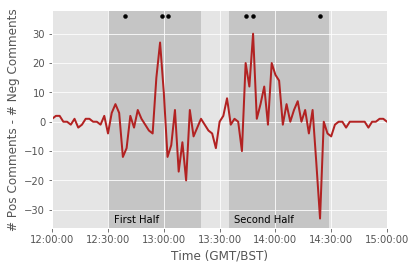

In [9]:
fig,ax = plt.subplots(1)
ax = plot_figure(posneg_df,ax)
ax.set_ylabel('# Pos Comments - # Neg Comments')

# MATCH EVENTS (BELOW HERE) MIGHT HAVE TO CHANGE
# Get y axis lims to place events
scatter_y_min, scatter_y_max = ax.get_ylim()
# Place match events
ax.scatter(goal,np.tile(scatter_y_max,len(goal)),color='black',s=15)
ax.scatter(penalty,np.tile(scatter_y_max,len(penalty)),color='black',s=15)
# Define first and second half
ax.fill_between([kickoff[1],halftime[0]],scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05),facecolor='dimgray',alpha=0.25,zorder=0)
ax.fill_between([kickoff[0],fulltime[0]],scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05),facecolor='dimgray',alpha=0.25,zorder=0)
ax.text(datetime.time(kickoff[1].hour,kickoff[1].minute+3),scatter_y_min+np.abs(scatter_y_min*0.05),'First Half')
ax.text(datetime.time(kickoff[0].hour,kickoff[0].minute+3),scatter_y_min+np.abs(scatter_y_min*0.05),'Second Half')
# Rescale ylim to encmpass match events
ax.set_ylim([scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05)])
# Save
fig.savefig('./figures/' + analysis_name +  '.png',dpi=300)
fig.savefig('./figures/' + analysis_name +  '.pdf',dpi=300)

### Plot figure (weighted)

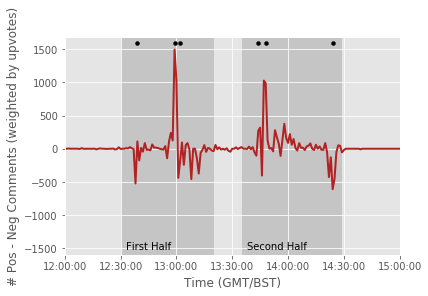

In [10]:
# Plot weighted figure
fig,ax = plt.subplots(1)
ax = plot_figure(weighted_posneg_df,ax)
ax.set_ylabel('# Pos - Neg Comments (weighted by upvotes)')

# MATCH EVENTS (BELOW HERE) MIGHT HAVE TO CHANGE
# Get y axis lims to place events
scatter_y_min, scatter_y_max = ax.get_ylim()
# Place match events
ax.scatter(goal,np.tile(scatter_y_max,len(goal)),color='black',s=15)
ax.scatter(penalty,np.tile(scatter_y_max,len(penalty)),color='black',s=15)
# Define first and second half
ax.fill_between([kickoff[1],halftime[0]],scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05),facecolor='dimgray',alpha=0.25,zorder=0)
ax.fill_between([kickoff[0],fulltime[0]],scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05),facecolor='dimgray',alpha=0.25,zorder=0)
ax.text(datetime.time(kickoff[1].hour,kickoff[1].minute+3),scatter_y_min+np.abs(scatter_y_min*0.05),'First Half')
ax.text(datetime.time(kickoff[0].hour,kickoff[0].minute+3),scatter_y_min+np.abs(scatter_y_min*0.05),'Second Half')
# Rescale ylim to encmpass match events
ax.set_ylim([scatter_y_min,scatter_y_max+np.abs(scatter_y_max*0.05)])
# Save
fig.savefig('./figures/weighted_' + analysis_name +  '.png',dpi=300)
fig.savefig('./figures/weighted_' + analysis_name +  '.pdf',dpi=300)